In [ ]:
#!pip install torch transformers pandas scikit-learn
#!pip install seaborn matplotlib

In [8]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
import pandas as pd
from torch.cuda.amp import GradScaler, autocast

df_train = pd.read_csv('data_train_combined.csv')
df_val = pd.read_csv('data_val_combined.csv')
df_test = pd.read_csv('data_test_combined.csv')

df_train['clean_text'] = df_train['text'].apply(clean_text)
df_val['clean_text'] = df_val['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(df, tokenizer, max_length=128):
    texts = df['clean_text'].tolist()
    labels = df['label'].map({'hate': 1, 'nothate': 0}).tolist()

    encodings = tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels))

train_dataset = preprocess_data(df_train, tokenizer)
val_dataset = preprocess_data(df_val, tokenizer)
test_dataset = preprocess_data(df_test, tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

scaler = GradScaler()
accumulation_steps = 4

epochs = 3
best_val_loss = float('inf')
patience = 2
epochs_without_improvement = 0

In [ ]:

def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()
    return total_loss / len(dataloader)



def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), classification_report(true_labels, predictions, target_names=['nothate', 'hate'])

In [ ]:
#train model

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_report = evaluate(model, val_loader, loss_fn, device)

    print(f"Epoch {epoch + 1}/{epochs}", flush=True)
    print(f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}", flush=True)
    print("Validation Report:")
    print(val_report)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping!")
            break

model.load_state_dict(torch.load('best_model.pth'))

test_loss, test_report = evaluate(model, test_loader, loss_fn, device)
print("\nTest Results:")
print(f"Test Loss: {test_loss:.3f}")
print("Test Report:")
print(test_report)

model.save_pretrained('bert_hate_speech_detector_pytorch')
tokenizer.save_pretrained('bert_hate_speech_detector_pytorch')

def predict_hate_speech(text, model, tokenizer, device):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=128,
        truncation=True,
        padding='max_length'
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probas = torch.nn.functional.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probas).item()

    return {
        'prediction': 'hate' if prediction == 1 else 'nothate',
        'hate_probability': f"{probas[0][1].item():.4f}",
        'nothate_probability': f"{probas[0][0].item():.4f}"
    }

test_text = "Immigrants are stealing our jobs"
print(f"\nPrediction for '{test_text}': {predict_hate_speech(test_text, model, tokenizer, device)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-10-bfe144feef6c>:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-10-bfe144feef6c>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3
Train Loss: 0.133, Val Loss: 0.467
Validation Report:
              precision    recall  f1-score   support

     nothate       0.78      0.67      0.72      2557
        hate       0.76      0.85      0.80      3107

    accuracy                           0.77      5664
   macro avg       0.77      0.76      0.76      5664
weighted avg       0.77      0.77      0.77      5664



<ipython-input-10-bfe144feef6c>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/3
Train Loss: 0.106, Val Loss: 0.459
Validation Report:
              precision    recall  f1-score   support

     nothate       0.80      0.68      0.74      2557
        hate       0.77      0.86      0.81      3107

    accuracy                           0.78      5664
   macro avg       0.79      0.77      0.77      5664
weighted avg       0.78      0.78      0.78      5664



<ipython-input-10-bfe144feef6c>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/3
Train Loss: 0.087, Val Loss: 0.515
Validation Report:
              precision    recall  f1-score   support

     nothate       0.81      0.64      0.71      2557
        hate       0.75      0.88      0.81      3107

    accuracy                           0.77      5664
   macro avg       0.78      0.76      0.76      5664
weighted avg       0.77      0.77      0.76      5664



<ipython-input-10-bfe144feef6c>:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Results:
Test Loss: 0.497
Test Report:
              precision    recall  f1-score   support

     nothate       0.76      0.62      0.68      3378
        hate       0.75      0.86      0.80      4592

    accuracy                           0.76      7970
   macro avg       0.76      0.74      0.74      7970
weighted avg       0.76      0.76      0.75      7970


Prediction for 'Immigrants are stealing our jobs': {'prediction': 'hate', 'hate_probability': '0.9815', 'nothate_probability': '0.0185'}


In [26]:
test_text = "This country's heat is killing me"
print(f"\nPrediction for '{test_text}': {predict_hate_speech(test_text, model, tokenizer, device)}")


Prediction for 'This country's heat is killing me': {'prediction': 'nothate', 'hate_probability': '0.0168', 'nothate_probability': '0.9832'}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_with_confusion_matrix(model, dataloader, device, df_test):
    model.eval()
    predictions, true_labels, texts = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            batch_texts = df_test.iloc[len(texts):len(texts) + len(labels)]['clean_text'].tolist()
            texts.extend(batch_texts)

    return true_labels, predictions, texts

true_labels, predictions, texts = evaluate_with_confusion_matrix_and_text(model, test_loader, device, df_test)

for i in range(5):
    print(f"Text: {texts[i]}")
    print(f"True Label: {true_labels[i]} ({'hate' if true_labels[i] == 1 else 'nothate'})")
    print(f"Predicted Label: {predictions[i]} ({'hate' if predictions[i] == 1 else 'nothate'})")
    print("-" * 50)

Text: bananas black people
True Label: 1 (hate)
Predicted Label: 1 (hate)
--------------------------------------------------
Text: asian people shit
True Label: 0 (nothate)
Predicted Label: 0 (nothate)
--------------------------------------------------
Text: women reproduce kids men cases
True Label: 1 (hate)
Predicted Label: 1 (hate)
--------------------------------------------------
Text: hate wearing black summer
True Label: 0 (nothate)
Predicted Label: 0 (nothate)
--------------------------------------------------
Text: cares chinese people think
True Label: 1 (hate)
Predicted Label: 1 (hate)
--------------------------------------------------


NameError: name 'plot_confusion_matrix' is not defined

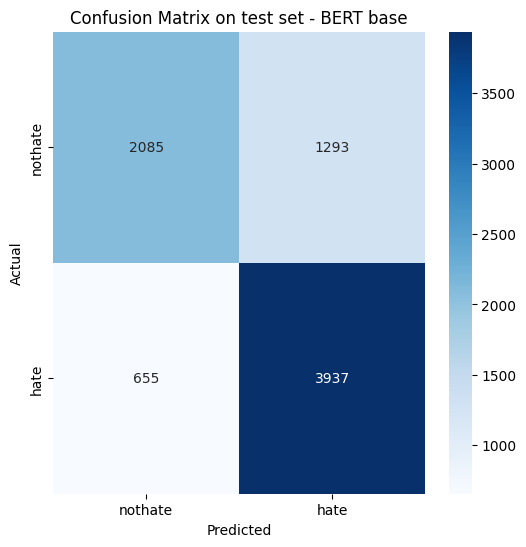

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix on test set - BERT base')
    plt.show()

plot_confusion_matrix(true_labels, predictions, class_names=['nothate', 'hate'])